# Clasificador Random Forest 

## Importamos las librerias a utilizar

In [2]:
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Cargamos el df

In [3]:
from google.colab import drive
drive.mount('/content/drive')

hotel = pd.read_csv('/content/drive/MyDrive/Kung Fu Pandas/hotels_train.csv')
hotel_t = pd.read_csv('/content/drive/MyDrive/Kung Fu Pandas/hotels_test.csv')

Mounted at /content/drive


## Analisis exploratorio

Elimino las filas con 'adr' > 0 y creo una copia del df original

In [4]:
hotel = hotel[hotel['adr']>0]
hotel_orig = hotel_t.copy()
hotel.shape

(61028, 32)

Listo las columnas

In [5]:
hotel.columns.tolist()

['hotel',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status_date',
 'id',
 'is_canceled']

Muestro algunas filas

In [6]:
hotel.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,9.0,NaN,0,Transient,115.5,0,1,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,NaN,0,Transient,42.0,1,0,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,9.0,NaN,0,Transient,229.0,0,2,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0.0,...,154.0,NaN,0,Transient,75.0,0,0,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0.0,...,20.0,NaN,0,Transient-Party,75.0,0,1,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0


## Preprocesamiento

Imputo valores faltantes

In [7]:
hotel['children'].fillna(0,inplace = True)
hotel['country'].fillna('PRT',inplace = True)
hotel['agent'].fillna(0,inplace = True)
hotel['company'].fillna(0,inplace = True)

<ipython-input-7-91881aae9238>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel['children'].fillna(0,inplace = True)
<ipython-input-7-91881aae9238>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel['country'].fillna('PRT',inplace = True)
<ipython-input-7-91881aae9238>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel['agent'].fillna(0,inplace = True)
<ipython-input-7-91881aae9238>:4: SettingWithCopyWarning: 
A value is 

y elimino las columnas innecesarias tal como lo hicimos en modelos anteriores

In [8]:
columnas_eliminar=['meal','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','id','reservation_status_date']
hotel.drop(columnas_eliminar, axis='columns', inplace=True)
hotel_t.drop(columnas_eliminar, axis='columns', inplace=True)
hotel.columns.tolist()

<ipython-input-8-ab72810bb20e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel.drop(columnas_eliminar, axis='columns', inplace=True)


['hotel',
 'lead_time',
 'arrival_date_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'is_canceled']

Formateo las columnas para eliminar variables categoricas

In [9]:
def higher_probability(a,b):
    if a == b:
        return 0
    else:
        return 1

hotel['hotel'] = hotel['hotel'].map({'City Hotel':1,'Resort Hotel':0},na_action=None)
hotel['arrival_date_month'] = hotel['arrival_date_month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12},na_action=None)
hotel['country'] = hotel['country'].apply(higher_probability,b='PTR')
hotel['market_segment'] = hotel['market_segment'].map({'Online TA':1,'Groups':2,'Offline TA/TO':3,'Direct':4,'Complementary':5,'Corporate':6,'Aviation':7,'Undefined':8},na_action=None)
hotel['distribution_channel'] = hotel['distribution_channel'].map({'TA/TO':1,'Direct':2,'Corporate':3,'GDS':4,'Undefined':5},na_action=None)
hotel['reserved_room_type'] = hotel['reserved_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10},na_action=None)
hotel['assigned_room_type'] = hotel['assigned_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10,'K':11,'I':12},na_action=None)
hotel['agent'] = hotel['agent'].apply(higher_probability,b=0)
hotel['company'] = hotel['company'].apply(higher_probability,b=0)


hotel_t['hotel'] = hotel_t['hotel'].map({'City Hotel':1,'Resort Hotel':0},na_action=None)
hotel_t['arrival_date_month'] = hotel_t['arrival_date_month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12},na_action=None)
hotel_t['country'] = hotel_t['country'].apply(higher_probability,b='PTR')
hotel_t['market_segment'] = hotel_t['market_segment'].map({'Online TA':1,'Groups':2,'Offline TA/TO':3,'Direct':4,'Complementary':5,'Corporate':6,'Aviation':7,'Undefined':8},na_action=None)
hotel_t['distribution_channel'] = hotel_t['distribution_channel'].map({'TA/TO':1,'Direct':2,'Corporate':3,'GDS':4,'Undefined':5},na_action=None)
hotel_t['reserved_room_type'] = hotel_t['reserved_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10},na_action=None)
hotel_t['assigned_room_type'] = hotel_t['assigned_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10,'K':11,'I':12},na_action=None)
hotel_t['agent'] = hotel_t['agent'].apply(higher_probability,b=0)
hotel_t['company'] = hotel_t['company'].apply(higher_probability,b=0)

hotel.head()

<ipython-input-9-e6785b045e81>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel['hotel'] = hotel['hotel'].map({'City Hotel':1,'Resort Hotel':0},na_action=None)
<ipython-input-9-e6785b045e81>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel['arrival_date_month'] = hotel['arrival_date_month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12},na_action=None)
<ipython-input-9-e6785b045e81>:9: SettingWithCopy

,hotel,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,country,market_segment,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
0,1,49,9,1,2,1,0.0,0,1,1,...,0,No Deposit,1,0,0,Transient,115.5,0,1,1
1,0,4,10,0,1,2,0.0,0,1,2,...,0,No Deposit,0,0,0,Transient,42.0,1,0,0
2,1,25,10,0,1,2,2.0,0,1,1,...,0,No Deposit,1,0,0,Transient,229.0,0,2,0
3,1,26,12,2,5,2,0.0,0,1,2,...,0,Non Refund,1,0,0,Transient,75.0,0,0,1
4,1,104,3,2,5,2,0.0,0,1,3,...,0,No Deposit,1,0,0,Transient-Party,75.0,0,1,0


Realizo One Hot Encoding para otras columnas

In [10]:
#Dummies para deposit_type
hotel = pd.get_dummies(hotel, columns=['deposit_type'], drop_first=True)
hotel_t = pd.get_dummies(hotel_t, columns=['deposit_type'], drop_first=True)

#Dummies para customer_type
hotel = pd.get_dummies(hotel, columns=['customer_type'], drop_first=True)
hotel_t = pd.get_dummies(hotel_t, columns=['customer_type'], drop_first=True)

Nos fijamos como quedaron los valores

In [11]:
total_filas = hotel.shape[0]
print(hotel.isna().sum()/total_filas*100)

hotel                             0.0
lead_time                         0.0
arrival_date_month                0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
country                           0.0
market_segment                    0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
assigned_room_type                0.0
booking_changes                   0.0
agent                             0.0
company                           0.0
days_in_waiting_list              0.0
adr                               0.0
required_car_parking_spaces       0.0
total_of_special_requests         0.0
is_canceled                       0.0
deposit_type_Non Refund           0.0
deposit_type_Refundable           0.0
customer_typ

## Entrenamiento y Prediccion

In [12]:
target='is_canceled'
hotel_x=hotel.drop([target], axis='columns', inplace=False)


#Creo un dataset con la variable target
hotel_y = hotel[target].copy()

x_train, x_test, y_train, y_test = train_test_split(hotel_x.values, 
                                                    hotel_y.values, 
                                                    test_size=0.20,    #20% al conjunto de test
                                                    random_state=10,  #para poder reproducir el experimento
                                                    stratify=hotel[target].values) #estratificado para mantener proporcion

Creamos el Random Forest y buscamos los mejores parametros

In [13]:
rf_cv = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [1, 5, 10], 
               "min_samples_split" : [2, 4, 10, 12, 16], 
               "n_estimators": [10, 20, 50] }

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator = rf_cv, param_grid = param_grid, scoring = "accuracy", cv = 8, n_jobs = -1)
gs_fit = gs.fit(X = x_train, y = y_train)

Veo los mejores parametros

In [14]:
rf_cv_best=gs_fit.best_estimator_
gs_fit.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50}

Y predigo usando el mejor modelo

In [15]:
y_pred_rf_cv_best = rf_cv_best.predict(x_test)

Muestro la matriz de confusion y los scores correspondientes

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      6049
           1       0.85      0.83      0.84      6157

    accuracy                           0.84     12206
   macro avg       0.84      0.84      0.84     12206
weighted avg       0.84      0.84      0.84     12206



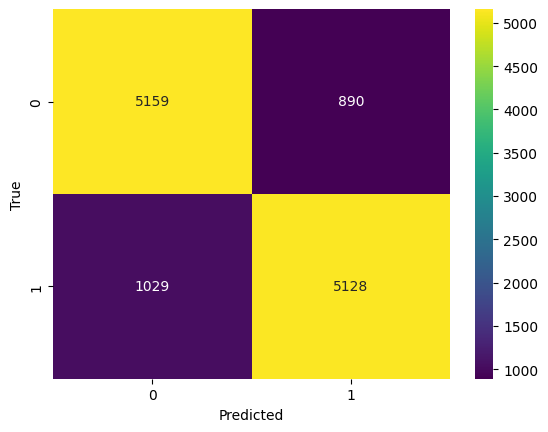

In [16]:
tabla=confusion_matrix(y_test,y_pred_rf_cv_best)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='viridis',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred_rf_cv_best))

In [17]:
#Evaluo la performance en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred_rf_cv_best)
recall=recall_score(y_test,y_pred_rf_cv_best)
f1=f1_score(y_test,y_pred_rf_cv_best)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.8427822382434869
Recall: 0.8328731525093389
f1 score: 0.842381930184805


In [19]:
import pickle

filename = "random_forest.pickle"

pickle.dump(rf_cv_best, open(filename, "wb"))